<a href="https://colab.research.google.com/github/prashantmalan/MarketRisk/blob/main/FRTBSA_DRC_MAR21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Risk Charge (DRC) Under FRTB Standardized Approach

This notebook provides a detailed explanation of the Default Risk Charge (DRC) under the Fundamental Review of the Trading Book (FRTB) Standardized Approach. It's designed for risk professionals who want to understand the DRC calculation methodology, even if they don't have deep market risk expertise.

## Contents

1. **Introduction to DRC**
2. **DRC Conceptual Framework**
3. **Gross JTD Calculation**
4. **Net JTD and Bucketing**
5. **Risk Weights and Final DRC Calculation**
6. **Practical Example - Complete DRC Calculation**
7. **Conclusion**

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math

# Set visualization style
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Introduction to DRC

The Default Risk Charge (DRC) is a key component of the Fundamental Review of the Trading Book (FRTB) Standardized Approach (SA). It's designed to capture the jump-to-default risk - the risk that a credit instrument loses a significant portion of its value if the issuer defaults.

DRC replaces the incremental risk charge (IRC) from Basel 2.5 and aims to provide a more robust measure of default risk in the trading book. Unlike the sensitivity-based approach which focuses on market risk factors, DRC specifically addresses credit default events.

According to the BIS FRTB framework, the DRC applies to:
- Non-securitization credit products
- Securitization products not included in the correlation trading portfolio (non-CTP)
- Securitization products in the correlation trading portfolio (CTP)

## DRC Conceptual Framework

The Default Risk Charge (DRC) under FRTB:

1. Applies to debt instruments, equity instruments, and certain derivatives
2. Is calculated separately from the sensitivities-based method
3. Recognizes hedging relationships within defined buckets
4. Uses a formula based on Loss Given Default (LGD), probability of default (PD), and exposure amounts
5. Differentiates between non-securitization and securitization exposures

## Gross JTD Calculation

The first step in the DRC calculation is to determine gross jump-to-default (JTD) risk positions for each instrument. The JTD risk position represents the estimated loss in the event of a default.

### For Debt Instruments (Long Positions):

The gross JTD for a long position in a debt instrument is calculated as:

$$\text{Gross JTD} = \text{Notional} \times (1 - \text{Recovery Rate}) - (\text{Market Value} - \text{Notional})$$


### For CDS and Short Positions:

For a short debt position or a bought CDS protection:

$$\text{Gross JTD} = \text{Notional} \times (\text{Recovery Rate} - 1) - (\text{Notional} - \text{Market Value})$$


Let's implement this calculation for a simple bond:

In [17]:
# Function to calculate gross JTD for a bond
def calculate_gross_jtd_bond(notional, market_value, recovery_rate, is_long=True):
    """
    Calculate the gross JTD for a simple bond position

    Parameters:
    notional (float): Face value of the bond
    market_value (float): Current market value of the bond
    recovery_rate (float): Expected recovery rate in case of default (0-1)
    is_long (bool): Whether the position is long (True) or short (False)

    Returns:
    float: Gross JTD amount
    """
    if is_long:
        # For a long position in a bond:
        # Gross JTD = Notional × (1 - Recovery Rate) - (Market Value - Notional)
        # Simplified to: Gross JTD = Notional × (2 - Recovery Rate) - Market Value
        gross_jtd = notional * (2 - recovery_rate) - market_value
    else:
        # For a short position in a bond:
        # Gross JTD = Notional × (Recovery Rate - 1) - (Notional - Market Value)
        # Simplified to: Gross JTD = Market Value - Notional × (2 - Recovery Rate)
        gross_jtd = market_value - notional * (2 - recovery_rate)

    return gross_jtd

# Example bond parameters
example_bond = {
    "name": "Corporate Bond A",
    "notional": 1000000,  # $1 million
    "market_value": 980000,  # $980,000
    "recovery_rate": 0.4,  # 40%
    "credit_quality": "BBB"
}

# Calculate gross JTD for a long position
gross_jtd_long = calculate_gross_jtd_bond(
    example_bond["notional"],
    example_bond["market_value"],
    example_bond["recovery_rate"],
    is_long=True
)

# Calculate gross JTD for a short position (same bond, but short)
gross_jtd_short = calculate_gross_jtd_bond(
    example_bond["notional"],
    example_bond["market_value"],
    example_bond["recovery_rate"],
    is_long=False
)

print(f"Example Bond: {example_bond['name']}")
print(f"Notional: ${example_bond['notional']:,}")
print(f"Market Value: ${example_bond['market_value']:,}")
print(f"Recovery Rate: {example_bond['recovery_rate']*100}%")
print(f"Calculated Gross JTD (Long): ${gross_jtd_long:,.2f}")
print(f"Calculated Gross JTD (Short): ${gross_jtd_short:,.2f}")

Example Bond: Corporate Bond A
Notional: $1,000,000
Market Value: $980,000
Recovery Rate: 40.0%
Calculated Gross JTD (Long): $620,000.00
Calculated Gross JTD (Short): $-620,000.00


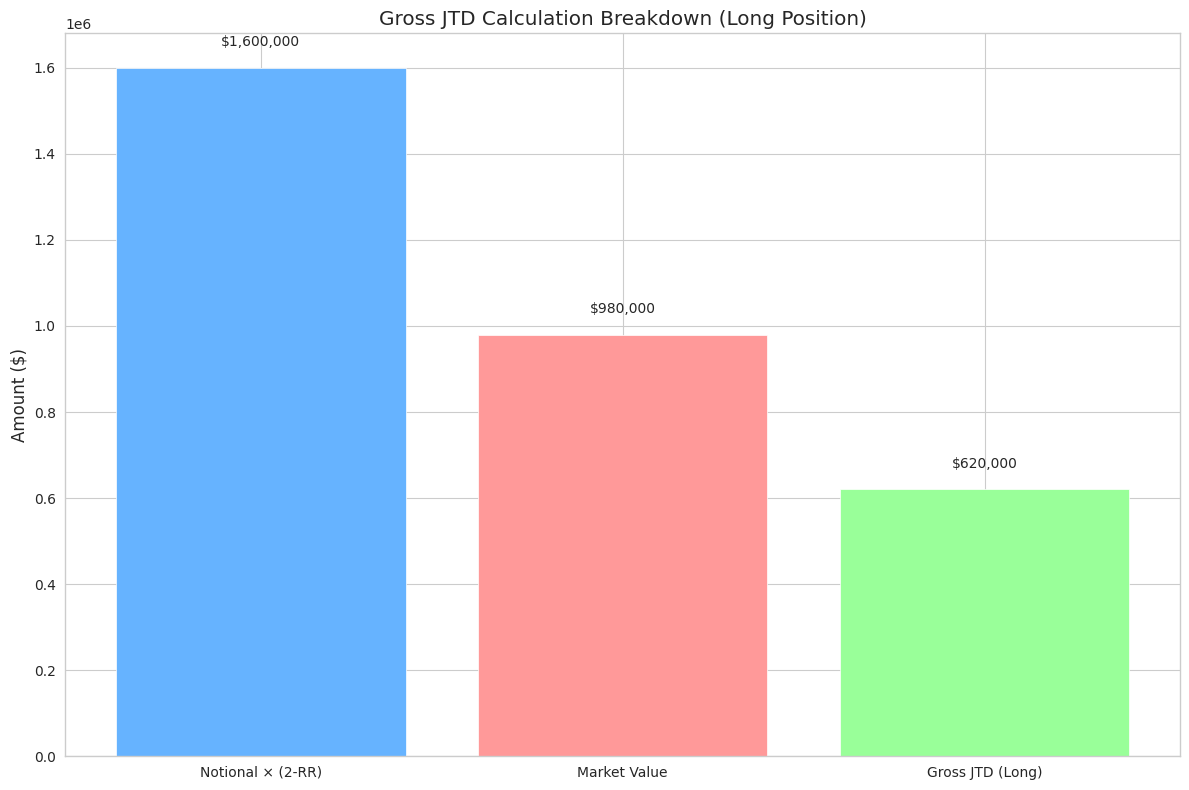

In [18]:
# Visualize the gross JTD calculation for a long position
labels = ['Notional × (2-RR)', 'Market Value', 'Gross JTD (Long)']
values = [example_bond["notional"] * (2 - example_bond["recovery_rate"]),
          example_bond["market_value"],
          gross_jtd_long]

fig, ax = plt.subplots()
colors = ['#66b3ff', '#ff9999', '#99ff99']
ax.bar(labels, values, color=colors)
ax.set_ylabel('Amount ($)')
ax.set_title('Gross JTD Calculation Breakdown (Long Position)')
# Add value labels on top of each bar
for i, v in enumerate(values):
    ax.text(i, v + 50000, f"${v:,.0f}", ha='center')
plt.tight_layout()
plt.show()

## Net JTD and Bucketing

After calculating gross JTD positions, we need to:

1. Net long and short positions from the same obligor
2. Apply hedging recognition rules
3. Assign positions to appropriate buckets based on:
   - Credit quality
   - Industry sector
   - Geographic region

The FRTB framework specifies different buckets for different types of exposures. For non-securitization exposures, buckets are typically defined by sector (e.g., sovereigns, financials, etc.) and credit quality.

In [19]:
# Create example portfolio with multiple positions
portfolio = pd.DataFrame({
    "Position": ["Corporate Bond A", "Corporate Bond B", "CDS on Corp A", "Corporate Bond C", "CDS on Corp D"],
    "Obligor": ["Company A", "Company B", "Company A", "Company C", "Company D"],
    "Gross JTD": [600000, 450000, -580000, 320000, -400000],
    "Bucket": ["Bucket 1", "Bucket 2", "Bucket 1", "Bucket 1", "Bucket 2"],
    "Risk Weight": [0.05, 0.03, 0.05, 0.05, 0.03]
})

print("Example Portfolio:")
display(portfolio)

# Net JTD by obligor
net_jtd_by_obligor = portfolio.groupby("Obligor")["Gross JTD"].sum().reset_index()
net_jtd_by_obligor.columns = ["Obligor", "Net JTD"]
print("\nNet JTD by Obligor:")
display(net_jtd_by_obligor)

Example Portfolio:


,Position,Obligor,Gross JTD,Bucket,Risk Weight
0,Corporate Bond A,Company A,600000,Bucket 1,0.05
1,Corporate Bond B,Company B,450000,Bucket 2,0.03
2,CDS on Corp A,Company A,-580000,Bucket 1,0.05
3,Corporate Bond C,Company C,320000,Bucket 1,0.05
4,CDS on Corp D,Company D,-400000,Bucket 2,0.03



Net JTD by Obligor:


,Obligor,Net JTD
0,Company A,20000
1,Company B,450000
2,Company C,320000
3,Company D,-400000


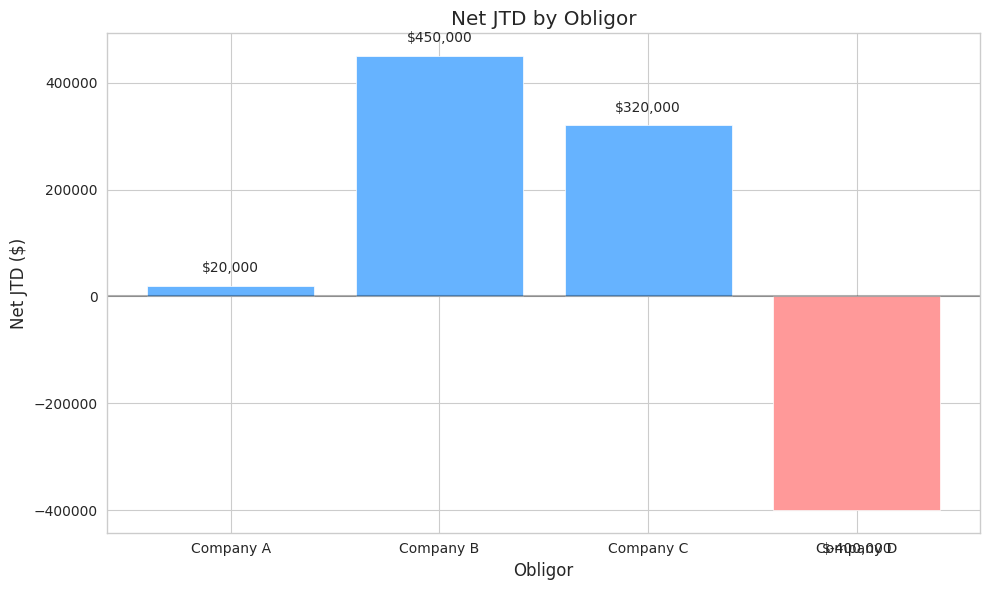

In [20]:
# Visualize net JTD by obligor
plt.figure(figsize=(10, 6))
bars = plt.bar(net_jtd_by_obligor["Obligor"], net_jtd_by_obligor["Net JTD"],
         color=[('#66b3ff' if x > 0 else '#ff9999') for x in net_jtd_by_obligor["Net JTD"]])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Obligor')
plt.ylabel('Net JTD ($)')
plt.title('Net JTD by Obligor')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.,
             height + (20000 if height > 0 else -60000),
             f'${int(height):,}',
             ha='center', va='bottom' if height > 0 else 'top')
plt.tight_layout()
plt.show()

## Risk Weights and Final DRC Calculation

According to the FRTB framework, each net JTD position is assigned a risk weight based on its credit quality. For non-securitization exposures:

1. Investment grade (IG) issuers: lower risk weights (e.g., 0.5% to 5.0%)
2. High yield (HY) and non-rated (NR) issuers: higher risk weights (e.g., 3.0% to 15.0%)
3. Defaulted entities have special treatment

After applying risk weights, the DRC is calculated using a formula that recognizes hedging benefits between long and short positions within the same bucket.

In [21]:
# Create a table of risk weights by credit quality
risk_weights = pd.DataFrame({
    "Credit Quality": ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Below CCC"],
    "Risk Weight": [0.005, 0.02, 0.03, 0.05, 0.075, 0.12, 0.14, 0.15],
    "Category": ["Investment Grade", "Investment Grade", "Investment Grade", "Investment Grade",
                "High Yield", "High Yield", "High Yield", "High Yield"]
})

print("Risk Weights by Credit Quality:")
display(risk_weights)

Risk Weights by Credit Quality:


,Credit Quality,Risk Weight,Category
0,AAA,0.005,Investment Grade
1,AA,0.020,Investment Grade
2,A,0.030,Investment Grade
3,BBB,0.050,Investment Grade
4,BB,0.075,High Yield
5,B,0.120,High Yield
6,CCC,0.140,High Yield
7,Below CCC,0.150,High Yield


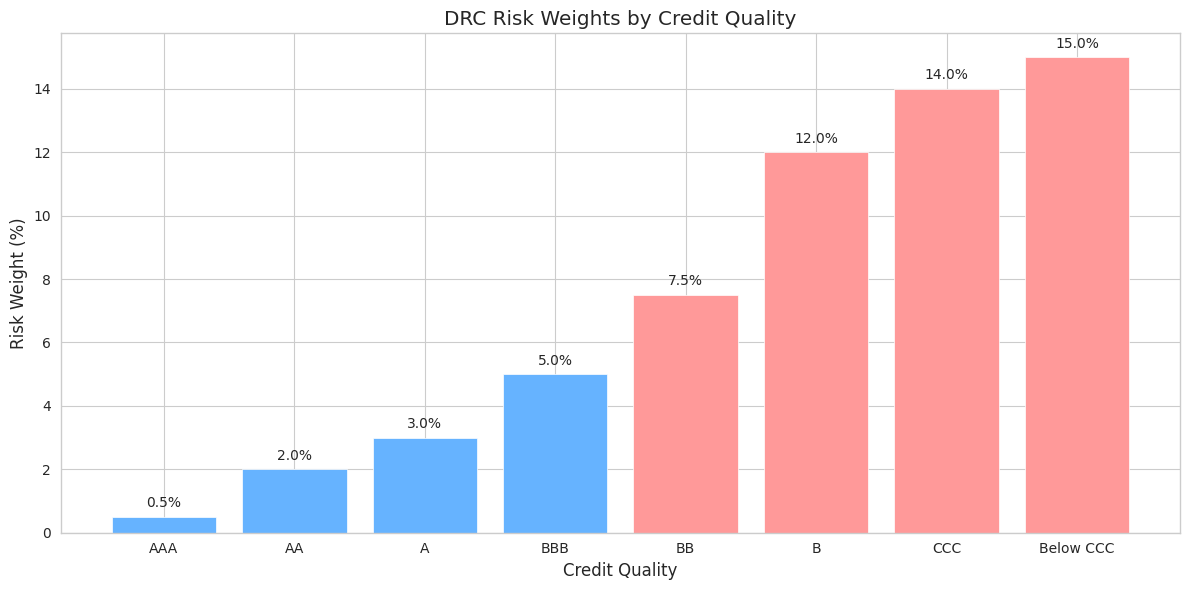

In [22]:
# Visualize risk weights
plt.figure(figsize=(12, 6))
bars = plt.bar(risk_weights["Credit Quality"], risk_weights["Risk Weight"] * 100,
         color=[('#66b3ff' if x == "Investment Grade" else '#ff9999') for x in risk_weights["Category"]])
plt.xlabel('Credit Quality')
plt.ylabel('Risk Weight (%)')
plt.title('DRC Risk Weights by Credit Quality')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3, f'{height:.1f}%', ha='center')
plt.tight_layout()
plt.show()

In [23]:
# Function to calculate weighted net JTD by bucket with  hedge benefit ratio
def calculate_drc_by_bucket(portfolio):
    # Group by bucket
    bucket_groups = portfolio.groupby("Bucket")

    drc_by_bucket = {}

    for bucket, group in bucket_groups:
        # Calculate weighted sum of long positions (positive JTD)
        long_positions = group[group["Gross JTD"] > 0]
        weighted_long = sum(long_positions["Gross JTD"] * long_positions["Risk Weight"])

        # Calculate weighted sum of short positions (negative JTD)
        short_positions = group[group["Gross JTD"] < 0]
        weighted_short = abs(sum(short_positions["Gross JTD"] * short_positions["Risk Weight"]))

        # Apply hedge benefit ratio according to FRTB formula
        # HBR = ∑ net JTDlong / (∑ net JTDlong + ∑|net JTDshort|)
        if weighted_long + weighted_short > 0:
            hedge_benefit_ratio = weighted_long / (weighted_long + weighted_short)
        else:
            hedge_benefit_ratio = 0

        # Calculate DRC for bucket
        # DRC = max(weighted_long - hedge_benefit_ratio * weighted_short, 0)
        drc = max(weighted_long - hedge_benefit_ratio * weighted_short, 0)

        drc_by_bucket[bucket] = {
            "Weighted Long": weighted_long,
            "Weighted Short": weighted_short,
            "Hedge Benefit Ratio": hedge_benefit_ratio,
            "DRC": drc
        }

    return drc_by_bucket

# Calculate DRC by bucket
drc_results = calculate_drc_by_bucket(portfolio)

# Display results
print("\nDRC Calculation by Bucket:")
for bucket, results in drc_results.items():
    print(f"\n{bucket}:")
    for key, value in results.items():
        if key == "Hedge Benefit Ratio":
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: ${value:,.2f}")


DRC Calculation by Bucket:

Bucket 1:
  Weighted Long: $46,000.00
  Weighted Short: $29,000.00
  Hedge Benefit Ratio: 0.6133
  DRC: $28,213.33

Bucket 2:
  Weighted Long: $13,500.00
  Weighted Short: $12,000.00
  Hedge Benefit Ratio: 0.5294
  DRC: $7,147.06


In [24]:
# Function to calculate final DRC
def calculate_final_drc(drc_by_bucket, correlation=0.5):
    """
    Calculate final DRC with correlation between buckets

    Parameters:
    drc_by_bucket (dict): DRC calculated for each bucket
    correlation (float): Correlation parameter between buckets

    Returns:
    dict: Final DRC value calculated using different methods
    """
    # Extract DRC values for each bucket
    bucket_drcs = [results["DRC"] for bucket, results in drc_by_bucket.items()]

    # Simple sum approach (no correlation)
    simple_sum = sum(bucket_drcs)

    # With correlation approach
    sum_squares = sum([drc**2 for drc in bucket_drcs])
    cross_terms = 0
    for i in range(len(bucket_drcs)):
        for j in range(i+1, len(bucket_drcs)):
            cross_terms += 2 * correlation * bucket_drcs[i] * bucket_drcs[j]

    with_correlation = math.sqrt(sum_squares + cross_terms)

    return {
        "Simple Sum": simple_sum,
        "With Correlation": with_correlation
    }

# Calculate final DRC
final_drc = calculate_final_drc(drc_results)

print("\nFinal DRC Calculation:")
for method, value in final_drc.items():
    print(f"{method}: ${value:,.2f}")


Final DRC Calculation:
Simple Sum: $35,360.39
With Correlation: $32,383.87


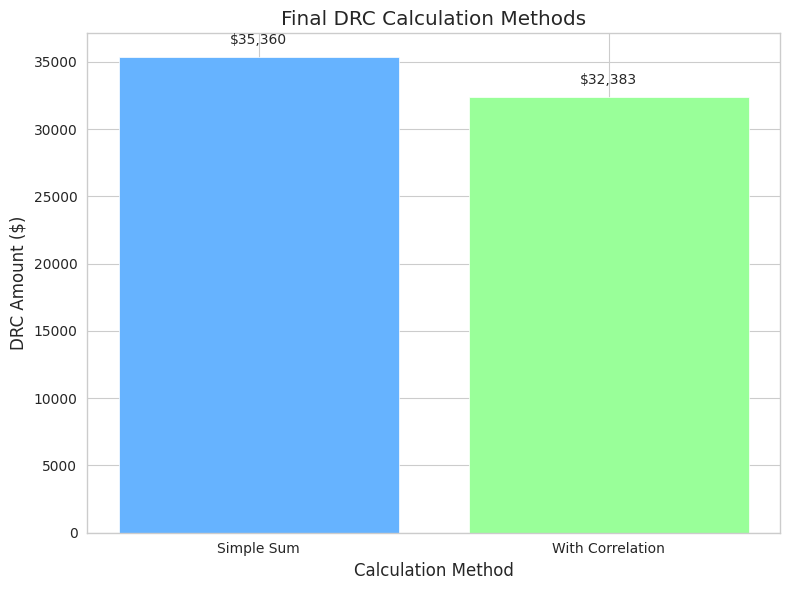

In [25]:
# Visualize final DRC calculation methods
plt.figure(figsize=(8, 6))
bars = plt.bar(final_drc.keys(), final_drc.values(), color=['#66b3ff', '#99ff99'])
plt.xlabel('Calculation Method')
plt.ylabel('DRC Amount ($)')
plt.title('Final DRC Calculation Methods')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000, f'${int(height):,}', ha='center')
plt.tight_layout()
plt.show()

## Practical Example - Complete DRC Calculation

Let's walk through a complete DRC calculation for a realistic portfolio of bonds and CDS instruments:

1. Define a portfolio with various credit instruments
2. Calculate gross JTD for each position
3. Net positions by obligor
4. Apply risk weights and bucket allocation
5. Calculate the final DRC

In [26]:
# Helper function to generate synthetic portfolio
def generate_synthetic_portfolio(n_positions=20):
    np.random.seed(42)  # For reproducibility

    obligors = [f"Obligor {i}" for i in range(1, 11)]
    instruments = ["Bond", "CDS", "Bond", "Bond"]  # More bonds than CDS
    buckets = ["Bucket 1", "Bucket 2", "Bucket 3"]
    credit_ratings = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC"]

    # Map credit ratings to risk weights based on earlier table
    risk_weight_map = {
        "AAA": 0.005, "AA": 0.02, "A": 0.03, "BBB": 0.05,
        "BB": 0.075, "B": 0.12, "CCC": 0.14
    }

    # Generate random portfolio data
    data = []
    for i in range(n_positions):
        obligor = np.random.choice(obligors)
        instrument = np.random.choice(instruments)
        rating = np.random.choice(credit_ratings, p=[0.05, 0.1, 0.2, 0.3, 0.2, 0.1, 0.05])  # Weighted probabilities

        # For bonds: positive JTD, for CDS: negative JTD (simplification)
        notional = np.random.randint(500000, 5000000)
        if instrument == "Bond":
            jtd_direction = 1
            position_name = f"{obligor} {rating} Bond"
        else:
            jtd_direction = -1
            position_name = f"CDS on {obligor} {rating}"

        # Apply some randomness to JTD calculation
        recovery_rate = 0.4 if rating in ["AAA", "AA", "A", "BBB"] else 0.3
        jtd_value = jtd_direction * notional * (1 - recovery_rate) * np.random.uniform(0.8, 1.2)

        # Assign to bucket (simplistic approach)
        if rating in ["AAA", "AA"]:
            bucket = "Bucket 1"
        elif rating in ["A", "BBB"]:
            bucket = "Bucket 2"
        else:
            bucket = "Bucket 3"

        data.append({
            "Position": position_name,
            "Obligor": obligor,
            "Instrument": instrument,
            "Rating": rating,
            "Notional": notional,
            "Gross JTD": jtd_value,
            "Bucket": bucket,
            "Risk Weight": risk_weight_map[rating]
        })

    return pd.DataFrame(data)

# Generate synthetic portfolio
synthetic_portfolio = generate_synthetic_portfolio(20)

# Display portfolio summary
print("Synthetic Portfolio Summary:")
display(synthetic_portfolio[['Position', 'Obligor', 'Rating', 'Gross JTD', 'Bucket']].head(10))
print(f"... and {len(synthetic_portfolio) - 10} more positions")

Synthetic Portfolio Summary:


,Position,Obligor,Rating,Gross JTD,Bucket
0,Obligor 7 CCC Bond,Obligor 7,CCC,1.595493e+06,Bucket 3
1,CDS on Obligor 7 A,Obligor 7,A,-1.125426e+06,Bucket 2
2,Obligor 4 BB Bond,Obligor 4,BB,1.865186e+06,Bucket 3
3,Obligor 2 CCC Bond,Obligor 2,CCC,1.137306e+06,Bucket 3
4,Obligor 6 BBB Bond,Obligor 6,BBB,8.586496e+05,Bucket 2
5,Obligor 10 A Bond,Obligor 10,A,1.179469e+06,Bucket 2
6,Obligor 3 BBB Bond,Obligor 3,BBB,1.866643e+06,Bucket 2
7,Obligor 5 BB Bond,Obligor 5,BB,1.730831e+06,Bucket 3
8,Obligor 9 BBB Bond,Obligor 9,BBB,1.822772e+06,Bucket 2
9,CDS on Obligor 5 BB,Obligor 5,BB,-2.632422e+06,Bucket 3


... and 10 more positions


In [27]:
# Calculate net JTD by obligor
net_jtd_synthetic = synthetic_portfolio.groupby("Obligor")["Gross JTD"].sum().reset_index()
net_jtd_synthetic.columns = ["Obligor", "Net JTD"]

print("\nNet JTD by Obligor (Top 5):")
display(net_jtd_synthetic.sort_values("Net JTD", ascending=False).head(5))


Net JTD by Obligor (Top 5):


,Obligor,Net JTD
0,Obligor 1,5.695942e+06
8,Obligor 8,2.949547e+06
1,Obligor 10,2.779376e+06
3,Obligor 3,1.866643e+06
9,Obligor 9,1.822772e+06


In [28]:
# Calculate DRC by bucket for synthetic portfolio
synthetic_drc_results = calculate_drc_by_bucket(synthetic_portfolio)

# Display results
print("\nDRC Calculation by Bucket:")
for bucket, results in synthetic_drc_results.items():
    print(f"\n{bucket}:")
    for key, value in results.items():
        if key == "Hedge Benefit Ratio":
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: ${value:,.2f}")


DRC Calculation by Bucket:

Bucket 1:
  Weighted Long: $70,739.42
  Weighted Short: $8,643.45
  Hedge Benefit Ratio: 0.8911
  DRC: $63,037.10

Bucket 2:
  Weighted Long: $393,941.63
  Weighted Short: $72,389.80
  Hedge Benefit Ratio: 0.8448
  DRC: $332,789.09

Bucket 3:
  Weighted Long: $1,196,174.43
  Weighted Short: $339,174.44
  Hedge Benefit Ratio: 0.7791
  DRC: $931,927.13


In [29]:
synthetic_drc_results

{'Bucket 1': {'Weighted Long': 70739.42167672825,
  'Weighted Short': 8643.445342437468,
  'Hedge Benefit Ratio': 0.891116992028637,
  'DRC': 63037.10066241144},
 'Bucket 2': {'Weighted Long': 393941.63137280045,
  'Weighted Short': 72389.79525765002,
  'Hedge Benefit Ratio': 0.8447674955541521,
  'DRC': 332789.0853293176},
 'Bucket 3': {'Weighted Long': 1196174.430324541,
  'Weighted Short': 339174.44077424053,
  'Hedge Benefit Ratio': 0.7790896602336976,
  'DRC': 931927.1305017835}}

In [30]:
# Calculate final DRC
synthetic_final_drc = calculate_final_drc(synthetic_drc_results)

print("\nFinal DRC Calculation:")
for method, value in synthetic_final_drc.items():
    print(f"{method}: ${value:,.2f}")


Final DRC Calculation:
Simple Sum: $1,327,753.32
With Correlation: $1,171,780.55


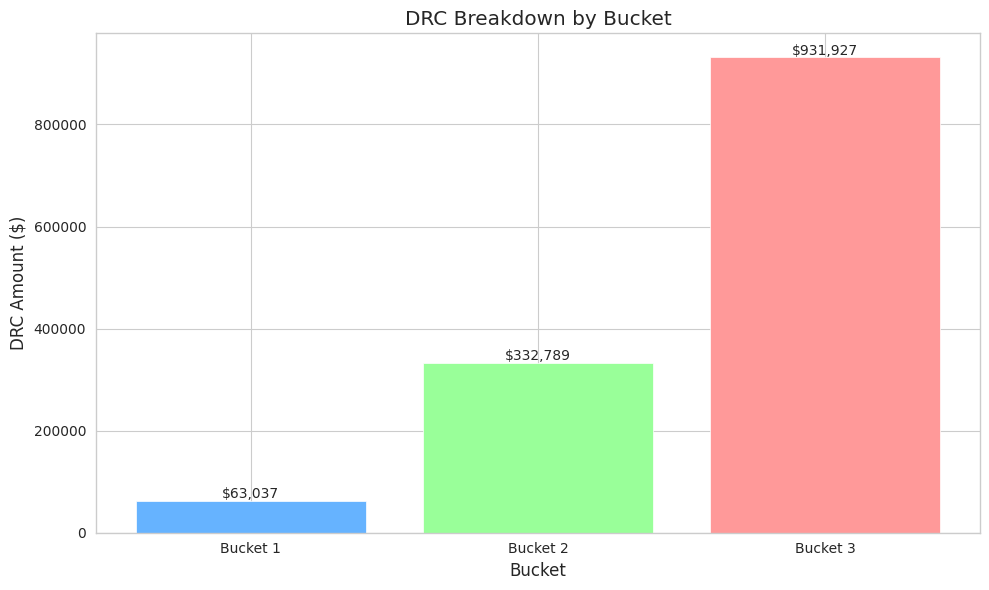

In [31]:
# Visualize the breakdown of final DRC by bucket
bucket_drcs = [results["DRC"] for bucket, results in synthetic_drc_results.items()]
bucket_names = list(synthetic_drc_results.keys())

plt.figure(figsize=(10, 6))
bars = plt.bar(bucket_names, bucket_drcs, color=['#66b3ff', '#99ff99', '#ff9999'])
plt.xlabel('Bucket')
plt.ylabel('DRC Amount ($)')
plt.title('DRC Breakdown by Bucket')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000, f'${int(height):,}', ha='center')
plt.tight_layout()
plt.show()

## Additional Analysis: Sensitivity to Risk Weights

Let's examine how changes in risk weights affect the final DRC calculation. This can help understand the sensitivity of the capital charge to credit quality adjustments.

In [32]:
# Function to perform sensitivity analysis on risk weights
def risk_weight_sensitivity(portfolio, stress_factors=[0.8, 1.0, 1.2, 1.5]):
    """
    Analyze sensitivity of DRC to changes in risk weights

    Parameters:
    portfolio (DataFrame): Portfolio data
    stress_factors (list): Factors to multiply risk weights by

    Returns:
    dict: DRC results under different stress scenarios
    """
    results = {}

    for factor in stress_factors:
        # Create a copy of the portfolio with adjusted risk weights
        stressed_portfolio = portfolio.copy()
        stressed_portfolio["Risk Weight"] = stressed_portfolio["Risk Weight"] * factor

        # Calculate DRC
        drc_by_bucket = calculate_drc_by_bucket(stressed_portfolio)
        final_drc = calculate_final_drc(drc_by_bucket)

        # Store results
        scenario_name = f"Stress Factor {factor:.2f}"
        results[scenario_name] = final_drc["With Correlation"]

    return results

# Run sensitivity analysis
sensitivity_results = risk_weight_sensitivity(synthetic_portfolio)

print("Risk Weight Sensitivity Analysis:")
for scenario, value in sensitivity_results.items():
    print(f"{scenario}: ${value:,.2f}")

Risk Weight Sensitivity Analysis:
Stress Factor 0.80: $937,424.44
Stress Factor 1.00: $1,171,780.55
Stress Factor 1.20: $1,406,136.66
Stress Factor 1.50: $1,757,670.82


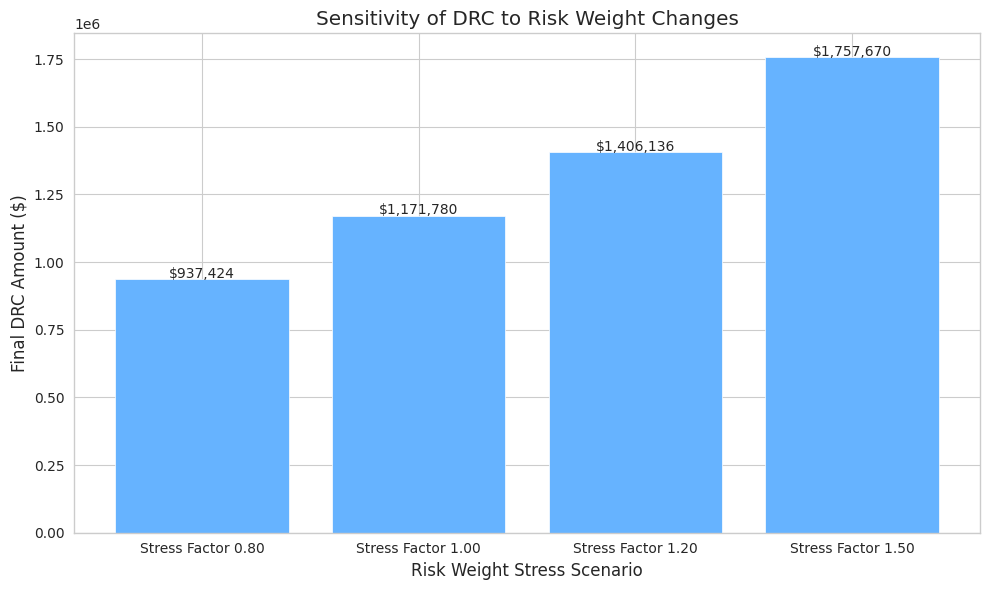

In [33]:
# Visualize sensitivity analysis
plt.figure(figsize=(10, 6))
bars = plt.bar(sensitivity_results.keys(), sensitivity_results.values(), color='#66b3ff')
plt.xlabel('Risk Weight Stress Scenario')
plt.ylabel('Final DRC Amount ($)')
plt.title('Sensitivity of DRC to Risk Weight Changes')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000, f'${int(height):,}', ha='center')
plt.tight_layout()
plt.show()

## Additional DRC Features for Specific Instruments

The DRC calculation has specific treatments for various instruments:

### Equity Instruments

For equity instruments, the FRTB framework specifies:
1. The JTD equivalent is the market value of the equity
2. The LGD for equity instruments is set at 100%
3. Equity positions receive the same risk weights as debt positions of the same obligor

### Credit Derivatives

For credit derivatives like CDS:
1. Protection seller: The JTD amount is the notional amount minus the current mark-to-market value
2. Protection buyer: The JTD amount is the current mark-to-market value minus the notional amount
3. Options on credit derivatives require special consideration

### Securitization Exposures

For securitization exposures:
1. Non-CTP securitizations have their own bucketing scheme and risk weights
2. CTP securitizations have a different treatment with their own correlation parameters
3. Re-securitizations receive special (higher) risk weights

In [34]:
# Function to calculate JTD for equity instruments
def calculate_jtd_equity(market_value, is_long=True):
    """
    Calculate JTD for equity positions

    Parameters:
    market_value (float): Current market value of the equity
    is_long (bool): Whether the position is long (True) or short (False)

    Returns:
    float: JTD amount
    """
    # For equity instruments, LGD is 100%
    if is_long:
        # For long equity: JTD = Market Value
        return market_value
    else:
        # For short equity: JTD = -Market Value
        return -market_value

# Example equity positions
equity_examples = [
    {"name": "Stock A (Long)", "market_value": 1000000, "is_long": True},
    {"name": "Stock B (Short)", "market_value": 500000, "is_long": False}
]

print("JTD Calculation for Equity Instruments:")
for eq in equity_examples:
    jtd = calculate_jtd_equity(eq["market_value"], eq["is_long"])
    print(f"{eq['name']}: Market Value = ${eq['market_value']:,}, JTD = ${jtd:,}")

JTD Calculation for Equity Instruments:
Stock A (Long): Market Value = $1,000,000, JTD = $1,000,000
Stock B (Short): Market Value = $500,000, JTD = $-500,000


## Conclusion

Key takeaways for understanding DRC under FRTB:

1. **Purpose**: DRC captures the jump-to-default risk in the trading book, complementing the sensitivities-based method that focuses on market risk factors.

2. **Calculation Process**:
   - Calculate gross JTD for each position
   - Net positions by obligor
   - Apply risk weights based on credit quality
   - Aggregate within buckets with hedge recognition
   - Aggregate across buckets with correlation assumptions

3. **Key Components**:
   - JTD calculation differs by instrument type (debt, equity, derivatives)
   - Hedging benefits are recognized with limitations via the hedge benefit ratio
   - Risk weights vary by credit quality and instrument type
   - Correlation assumptions affect the final capital requirement

4. **Practical Implementation**:
   - DRC requires detailed position data and proper bucketing
   - Sensitivity analysis helps understand the impact of different parameters
   - Regular recalibration is needed as portfolio composition changes

This notebook provided a step-by-step approach to understanding and calculating DRC, with practical code examples and visualizations to enhance comprehension.

## Next Steps

To further enhance your understanding and implementation of DRC:

1. Apply these calculations to your actual portfolio
2. Compare DRC results with your current methodology
3. Analyze the impacts of different portfolio compositions
4. Conduct sensitivity analysis on key parameters
5. Review specific requirements for securitizations if applicable
6. Ensure alignment with the latest regulatory updates

For a complete implementation, you should refer to the official FRTB text from the Basel Committee on Banking Supervision (BCBS) for the exact specifications and formulas.